## **1. Định nghĩa vấn đề**
- ### Input: Dữ liệu giá cổ phiếu VNM từ năm 2014 - 2024
- ### Output: Mô hình có hiệu suất tối ưu hơn

## **2. Chuẩn bị vấn đề**

#### ***Khai báo thư viện***


In [ ]:
import pandas as pd  # Thư viện xử lý dữ liệu dạng bảng
import numpy as np  # Thư viện xử lý mảng và tính toán số học

from IPython.display import display  # Hỗ trợ hiển thị nội dung trong Jupyter Notebook
import seaborn as sns  # Thư viện trực quan hóa dữ liệu
import matplotlib.pyplot as plt  # Thư viện vẽ biểu đồ cơ bản

from scipy.stats import kurtosis  # Tính độ nhọn của phân phối dữ liệu
from statsmodels.tsa.stattools import adfuller  # Kiểm định tính dừng của chuỗi thời gian (ADF Test)
from statsmodels.stats.outliers_influence import variance_inflation_factor  # Kiểm tra đa cộng tuyến (VIF)
from statsmodels.tools import add_constant  # Thêm hằng số vào dữ liệu
import statsmodels.api as sm  # Phân tích thống kê và mô hình hồi quy

from sklearn.feature_selection import RFE  # Lựa chọn đặc trưng quan trọng
from sklearn.linear_model import LinearRegression  # Xây dựng mô hình hồi quy tuyến tính
from sklearn.preprocessing import MinMaxScaler  # Chuẩn hóa dữ liệu về khoảng [0, 1]
from sklearn.model_selection import train_test_split  # Chia tập dữ liệu thành huấn luyện và kiểm tra
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                              r2_score, mean_absolute_percentage_error)  # Đánh giá hiệu suất mô hình

#### ***Load dataset***

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Read the CSV file from Google Drive
data = pd.read_csv('/content/drive/MyDrive/Data Analysis (Project)/Data/VNM_PriceHistory_20241126.csv')
data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Ngày,Đóng cửa,Mở,Cao,Thấp,KL,% Thay đổi
0,26/11/2024,"64,900.00","64,600.00","65,000.00","64,400.00",1.23M,0.93%
1,25/11/2024,"64,300.00","64,000.00","65,000.00","64,000.00",2.45M,0.00%
2,22/11/2024,"64,300.00","63,900.00","64,800.00","63,900.00",2.59M,0.63%
3,21/11/2024,"63,900.00","63,700.00","64,100.00","63,400.00",2.25M,0.47%
4,20/11/2024,"63,600.00","63,000.00","63,800.00","62,900.00",2.82M,0.95%
...,...,...,...,...,...,...,...
2714,8/1/2014,"94,444.00","93,750.00","94,444.00","93,750.00",56.02K,0.74%
2715,7/1/2014,"93,750.00","94,444.00","94,444.00","93,750.00",152.45K,-0.73%
2716,6/1/2014,"94,444.00","93,750.00","94,444.00","93,750.00",111.01K,0.00%
2717,3/1/2014,"94,444.00","93,750.00","94,444.00","93,750.00",44.21K,0.74%


## **3. Phân tích tổng quan và khám phá dữ liệu (Exploration Analyze Data - EDA)**


#### **3.1. Tổng quan về dữ liệu**


#### ***Kích thước và kiểu dữ liệu***


In [ ]:
print("Kiểu dữ liệu của từng cột:")
display(data.dtypes)

Kiểu dữ liệu của từng cột:


,0
Ngày,object
Đóng cửa,object
Mở,object
Cao,object
Thấp,object
KL,object
% Thay đổi,object


#### ***Xử lý kiểu dữ liệu***


In [ ]:
data['Ngày'] = pd.to_datetime(data['Ngày'], format='%d/%m/%Y')
cols_to_convert = ['Đóng cửa', 'Mở', 'Cao', 'Thấp']
for col in cols_to_convert:
    data[col] = data[col].str.replace(',', '').astype(float)
data['KL'] = data['KL'].str.replace('M', 'e6').str.replace('K', 'e3').astype(float)
data['% Thay đổi'] = data['% Thay đổi'].str.replace('%', '').astype(float)
display(data.dtypes)
data

,0
Ngày,datetime64[ns]
Đóng cửa,float64
Mở,float64
Cao,float64
Thấp,float64
KL,float64
% Thay đổi,float64


,Ngày,Đóng cửa,Mở,Cao,Thấp,KL,% Thay đổi
0,2024-11-26,64900.0,64600.0,65000.0,64400.0,1230000.0,0.93
1,2024-11-25,64300.0,64000.0,65000.0,64000.0,2450000.0,0.00
2,2024-11-22,64300.0,63900.0,64800.0,63900.0,2590000.0,0.63
3,2024-11-21,63900.0,63700.0,64100.0,63400.0,2250000.0,0.47
4,2024-11-20,63600.0,63000.0,63800.0,62900.0,2820000.0,0.95
...,...,...,...,...,...,...,...
2714,2014-01-08,94444.0,93750.0,94444.0,93750.0,56020.0,0.74
2715,2014-01-07,93750.0,94444.0,94444.0,93750.0,152450.0,-0.73
2716,2014-01-06,94444.0,93750.0,94444.0,93750.0,111010.0,0.00
2717,2014-01-03,94444.0,93750.0,94444.0,93750.0,44210.0,0.74


#### ***Sắp xếp dữ liệu tăng dần theo thời gian***


In [ ]:
data = data.sort_values(by='Ngày', ascending=True)
data = data.reset_index(drop=True)
data

,Ngày,Đóng cửa,Mở,Cao,Thấp,KL,% Thay đổi
0,2014-01-02,93750.0,93750.0,95139.0,93750.0,46830.0,0.00
1,2014-01-03,94444.0,93750.0,94444.0,93750.0,44210.0,0.74
2,2014-01-06,94444.0,93750.0,94444.0,93750.0,111010.0,0.00
3,2014-01-07,93750.0,94444.0,94444.0,93750.0,152450.0,-0.73
4,2014-01-08,94444.0,93750.0,94444.0,93750.0,56020.0,0.74
...,...,...,...,...,...,...,...
2714,2024-11-20,63600.0,63000.0,63800.0,62900.0,2820000.0,0.95
2715,2024-11-21,63900.0,63700.0,64100.0,63400.0,2250000.0,0.47
2716,2024-11-22,64300.0,63900.0,64800.0,63900.0,2590000.0,0.63
2717,2024-11-25,64300.0,64000.0,65000.0,64000.0,2450000.0,0.00


#### ***Thêm vào các cột cần thiết***

In [ ]:
# Thêm cột 'Đóng cửa (t+1)'
data['Đóng cửa (t+1)'] = data['Đóng cửa'].shift(-1)

# Kiểm tra dữ liệu đã chuyển đổi
display(data.dtypes)
display(data)

,0
Ngày,datetime64[ns]
Đóng cửa,float64
Mở,float64
Cao,float64
Thấp,float64
KL,float64
% Thay đổi,float64
Đóng cửa (t+1),float64


,Ngày,Đóng cửa,Mở,Cao,Thấp,KL,% Thay đổi,Đóng cửa (t+1)
0,2014-01-02,93750.0,93750.0,95139.0,93750.0,46830.0,0.00,94444.0
1,2014-01-03,94444.0,93750.0,94444.0,93750.0,44210.0,0.74,94444.0
2,2014-01-06,94444.0,93750.0,94444.0,93750.0,111010.0,0.00,93750.0
3,2014-01-07,93750.0,94444.0,94444.0,93750.0,152450.0,-0.73,94444.0
4,2014-01-08,94444.0,93750.0,94444.0,93750.0,56020.0,0.74,94444.0
...,...,...,...,...,...,...,...,...
2714,2024-11-20,63600.0,63000.0,63800.0,62900.0,2820000.0,0.95,63900.0
2715,2024-11-21,63900.0,63700.0,64100.0,63400.0,2250000.0,0.47,64300.0
2716,2024-11-22,64300.0,63900.0,64800.0,63900.0,2590000.0,0.63,64300.0
2717,2024-11-25,64300.0,64000.0,65000.0,64000.0,2450000.0,0.00,64900.0


#### **3.2. Kiểm tra tính toàn vẹn của dữ liệu**


***Kiểm tra dữ liệu trùng lặp***


In [ ]:
def check_duplicates(data):
    n_duplicated = data.duplicated(keep=False).sum()
    print(f'+ Số dòng trùng lặp: {n_duplicated}')

    if n_duplicated > 0:
        n_drop_duplicates = len(data[data.duplicated(keep="first")])
        print(f"+ Số dòng sẽ loại bỏ (giữ lại dòng đầu tiên): {n_drop_duplicates}")
        display(data[data.duplicated(keep="first")])

check_duplicates(data)

+ Số dòng trùng lặp: 0


***Kiểm tra dữ liệu thiếu***


In [ ]:
def check_nulls(data):
    null_counts = data.isnull().sum()
    display(null_counts)
    has_null = null_counts.any()

    if has_null:
        print("\nCác hàng có chứa giá trị Null:")
        display(data[data.isnull().any(axis=1)])

check_nulls(data)

,0
Ngày,0
Đóng cửa,0
Mở,0
Cao,0
Thấp,0
KL,1
% Thay đổi,0
Đóng cửa (t+1),1



Các hàng có chứa giá trị Null:


,Ngày,Đóng cửa,Mở,Cao,Thấp,KL,% Thay đổi,Đóng cửa (t+1)
2667,2024-09-16,71900.0,73000.0,73000.0,71900.0,NaN,-1.37,73400.0
2718,2024-11-26,64900.0,64600.0,65000.0,64400.0,1230000.0,0.93,NaN


#### ***Xử lý giá trị thiếu***


In [ ]:
# Kiểm tra số lượng giá trị null trước khi drop
print("Before drop:")
print(check_nulls(data))

# Loại bỏ dữ liệu chỉ ở cột 'KL'
data = data.dropna(subset=['KL', 'Đóng cửa (t+1)'])

# Reset lại index sau khi drop
data = data.reset_index(drop=True)

# Kiểm tra số lượng giá trị null sau khi drop
print("\nAfter drop:")
print(check_nulls(data))

Before drop:


,0
Ngày,0
Đóng cửa,0
Mở,0
Cao,0
Thấp,0
KL,1
% Thay đổi,0
Đóng cửa (t+1),1



Các hàng có chứa giá trị Null:


,Ngày,Đóng cửa,Mở,Cao,Thấp,KL,% Thay đổi,Đóng cửa (t+1)
2667,2024-09-16,71900.0,73000.0,73000.0,71900.0,NaN,-1.37,73400.0
2718,2024-11-26,64900.0,64600.0,65000.0,64400.0,1230000.0,0.93,NaN


None

After drop:


,0
Ngày,0
Đóng cửa,0
Mở,0
Cao,0
Thấp,0
KL,0
% Thay đổi,0
Đóng cửa (t+1),0


None


### **3.3. Phân tích phân phối**


#### ***Thống kê mô tả cơ bản***
  - *Count, Mean, Standard Deviation, Minimum Value*
  - *25th Percentile, 50th Percentile (Median), 75th Percentile, Maximum Value*


In [ ]:
data.describe()

,Ngày,Đóng cửa,Mở,Cao,Thấp,KL,% Thay đổi,Đóng cửa (t+1)
count,2717,2717.000000,2717.000000,2717.000000,2717.000000,2.717000e+03,2717.000000,2717.000000
mean,2019-06-19 05:03:09.473684480,93320.390099,93330.035885,94203.956975,92496.786382,1.673693e+06,0.000173,93309.219691
min,2014-01-02 00:00:00,58115.300000,58655.900000,59917.400000,58115.300000,3.977000e+04,-24.590000,58115.300000
25%,2016-09-29 00:00:00,73300.000000,73322.100000,74000.000000,72696.100000,6.101600e+05,-0.760000,73300.000000
50%,2019-06-24 00:00:00,89269.000000,89127.600000,90278.000000,88365.800000,1.210000e+06,0.000000,89203.700000
75%,2022-03-09 00:00:00,105769.000000,105690.000000,106424.000000,104900.000000,2.350000e+06,0.740000,105769.000000
max,2024-11-25 00:00:00,175578.000000,175333.000000,175742.000000,174189.000000,2.114000e+07,7.000000,175578.000000
std,NaN,24043.896545,24008.306955,24257.866784,23773.575472,1.561159e+06,1.623782,24050.550779


#### ***Phân phối các biến (Histogram, KDE)***


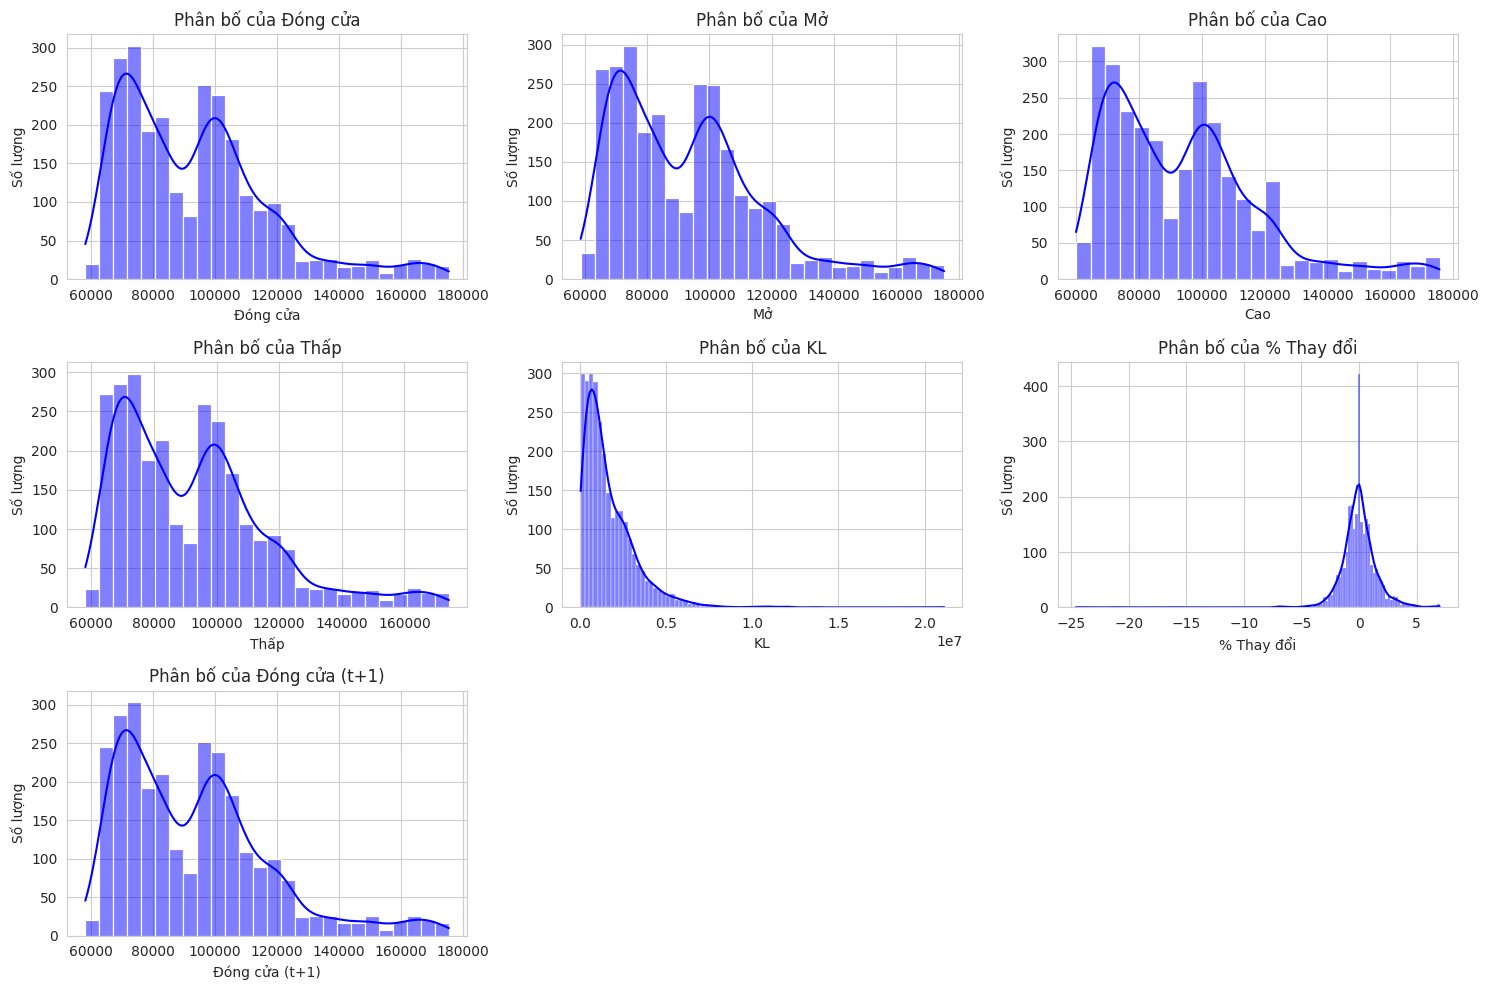

In [ ]:
def plot_distributions(data, figsize=(15, 10), rows_cols=(3, 3)):
    numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
    plt.figure(figsize=figsize)
    num_plots = len(numerical_columns)

    for i, col in enumerate(numerical_columns, 1):
        plt.subplot((num_plots // rows_cols[0]) + 1, rows_cols[1], i)
        sns.histplot(data[col], kde=True, color='b')
        plt.title(f'Phân bố của {col}')
        plt.ylabel('Số lượng')


    plt.tight_layout()
    plt.show()

plot_distributions(data)

Những biểu đồ phân bố này cho thấy sự phân bố của các biến trong tập dữ liệu của bạn. Các biểu đồ histogram và curve đi kèm (smooth curve) giúp bạn nhận diện được hình dạng phân phối của mỗi biến như:

- Giá Đóng cửa và Giá Đóng cửa ngày mai:
Phân phối hơi lệch trái, với phần lớn giá trị tập trung ở mức thấp và rải rác ở mức cao.

- Giá Mở cửa:
Tương tự Giá Đóng cửa, phân phối lệch trái với nhiều giá trị cao rải rác.

- Giá Cao nhất:
Phân phối lệch phải, đỉnh rơi gần giá trị trung bình, sau đó giảm dần.

- Giá Thấp nhất:
Lệch trái, tập trung nhiều giá trị thấp hơn.

- Khối lượng (KL):
Có sự biến động lớn với một vài giá trị cực cao.

- % Thay đổi:
Tập trung quanh giá trị trung bình, ít lệch trái hoặc phải.

Kết luận:
Dữ liệu có sự không tuyến tính và biến động lớn, đặc biệt ở các biến giá, cần lưu ý khi phân tích.

#### ***1. Boxplot***


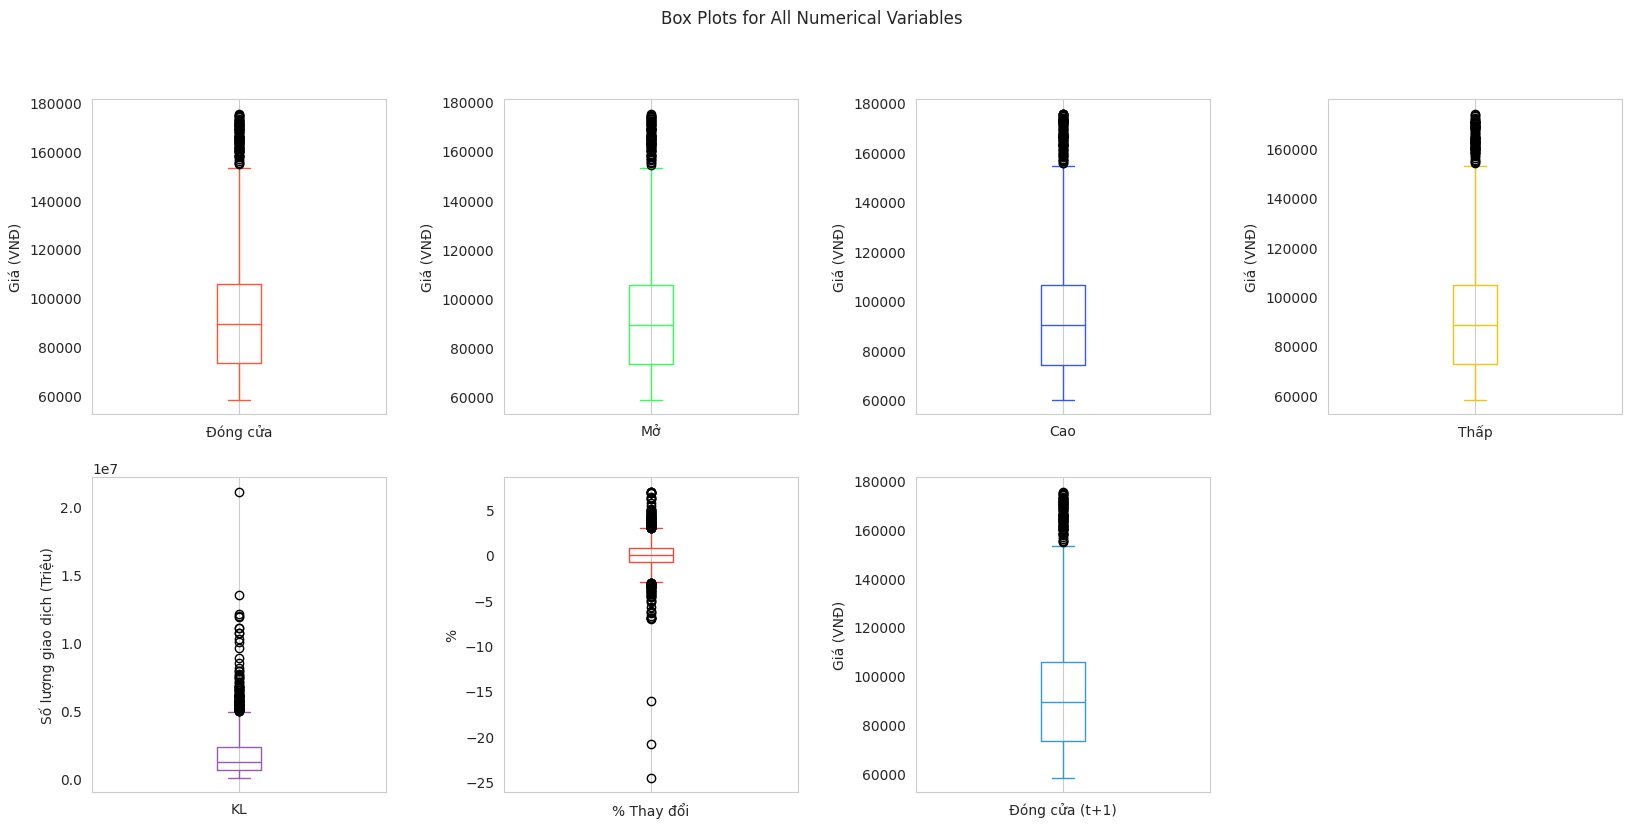

In [ ]:
def plot_boxplots_for_numerical_columns(df):
    numerical_columns = df.select_dtypes(include='number')
    plt.figure(figsize=(18, 9))
    num_rows = 2
    num_cols = 4
    colors = ['#FF5733', '#33FF57', '#3357FF', '#F1C40F', '#9B59B6', '#E74C3C', '#3498DB', '#3498DG' ]
    y_labels = ['Giá (VNĐ)', 'Giá (VNĐ)', 'Giá (VNĐ)', 'Giá (VNĐ)', 'Số lượng giao dịch (Triệu)', '%', 'Giá (VNĐ)']
    for i, column in enumerate(numerical_columns.columns):
        plt.subplot(num_rows, num_cols, i + 1)
        df[column].plot(kind='box', color=colors[i % len(colors)])
        plt.grid(axis='y')
        plt.ylabel(y_labels[i])
    plt.subplots_adjust(wspace=0.4, hspace=0.2, left=0.1, right=0.95)
    plt.suptitle("Box Plots for All Numerical Variables")
    plt.show()

plot_boxplots_for_numerical_columns(data)

**Nhận xét**

- Dựa vào boxplot ta nhìn thấy được các giá trị ngoại lệ dưới dạng các điểm nằm ngoài các hộp


#### ***2. Các giá trị ngoại lệ***

In [ ]:
# Tính IQR
Q1 = data['Đóng cửa (t+1)'].quantile(0.25)
Q3 = data['Đóng cửa (t+1)'].quantile(0.75)
IQR = Q3 - Q1

# Xác định các giá trị ngoại lệ
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Lọc các giá trị ngoại lệ
outliers = data[(data['Đóng cửa (t+1)'] < lower_bound) | (data['Đóng cửa (t+1)'] > upper_bound)]
outliers

,Ngày,Đóng cửa,Mở,Cao,Thấp,KL,% Thay đổi,Đóng cửa (t+1)
974,2017-11-30,151492.0,150113.0,153764.0,150032.0,1290000.0,0.92,159039.0
975,2017-12-01,159039.0,151736.0,159039.0,151736.0,1500000.0,4.98,164719.0
976,2017-12-04,164719.0,159039.0,166423.0,159039.0,1700000.0,3.57,161473.0
977,2017-12-05,161473.0,164719.0,166342.0,160662.0,852080.0,-1.97,158227.0
980,2017-12-08,152628.0,150924.0,156767.0,150924.0,1010000.0,1.13,154982.0
...,...,...,...,...,...,...,...,...
1059,2018-04-10,161028.0,161682.0,161682.0,159394.0,1310000.0,-0.40,160211.0
1060,2018-04-11,160211.0,160211.0,161437.0,159721.0,1020000.0,-0.51,160456.0
1061,2018-04-12,160456.0,160620.0,160865.0,159721.0,901420.0,0.15,159966.0
1062,2018-04-13,159966.0,161028.0,161028.0,159802.0,872530.0,-0.31,155307.0


#### ***Kiểm tra độ lệch và độ nhọn***

In [ ]:
# Kiểm Tra Độ Lệch và Độ Nhọn (Skewness, Kurtosis)
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
skew_kurt = pd.DataFrame(index=numerical_columns)
skew_kurt['Skewness'] = data[numerical_columns].skew()
skew_kurt['Kurtosis'] = data[numerical_columns].apply(kurtosis)
display(skew_kurt)

,Skewness,Kurtosis
Đóng cửa,1.087684,1.080096
Mở,1.086012,1.073253
Cao,1.100142,1.121999
Thấp,1.077012,1.041815
KL,2.636975,15.269209
% Thay đổi,-2.182335,34.332192
Đóng cửa (t+1),1.087517,1.078378


### **3.4. Phân tích tương quan giữa các biến**


#### **Ma trận tương quan (Correlation Matrix)**


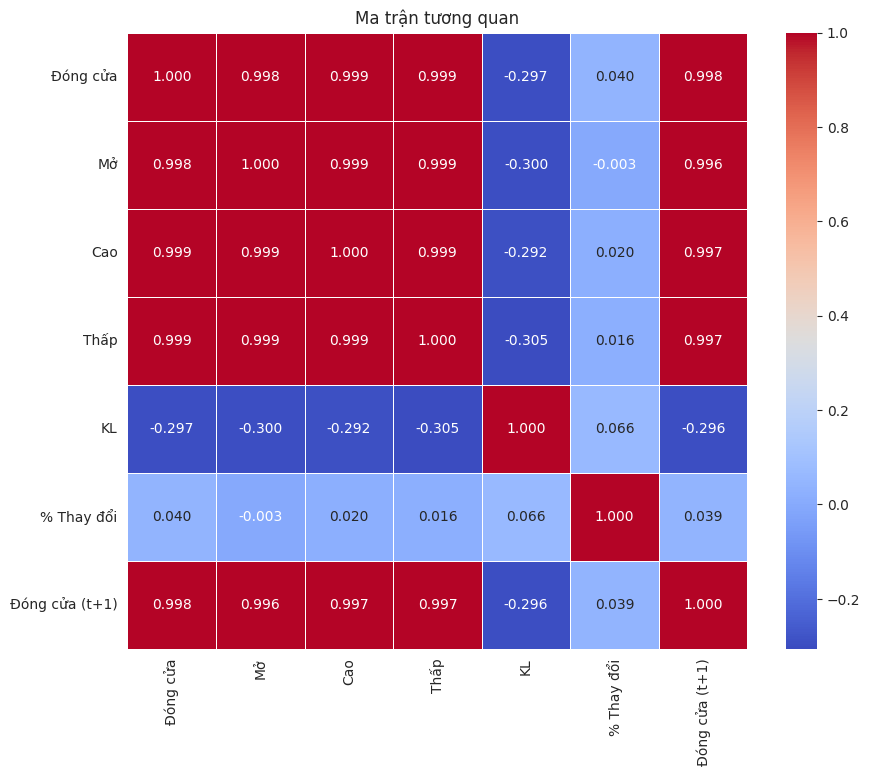

In [ ]:
def plot_correlation_matrix(data, figsize=(10, 8), title="Ma trận tương quan"):
    # Lặp qua các cột số trong DataFrame
    numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
    num_plots = len(numerical_columns)

    # Tính toán ma trận tương quan
    correlation_matrix = data[numerical_columns].corr()

    # Vẽ ma trận tương quan
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.5)

    # Đặt tiêu đề cho biểu đồ
    plt.title(title)
    plt.show()

plot_correlation_matrix(data)

Dựa trên ma trận tương quan của các biến trong dữ liệu, nhận xét như sau:
1.	Giá đóng cửa (Đóng cửa):
- **Giá mở (Mở), Giá cao (Cao), và Giá thấp (Thấp) đều có tương quan rất cao với giá đóng cửa, với giá trị gần 1**. Điều này cho thấy rằng **giá đóng cửa có sự liên quan mạnh mẽ với các biến này**, phản ánh mối quan hệ chặt chẽ giữa các giá trị khác nhau của giá.
- **Khối lượng (KL) và % thay đổi (% Thay đổi) có tương quan thấp hơn với giá đóng cửa, với giá trị âm hoặc gần 0**. Điều này có thể chỉ ra rằng **giá đóng cửa không bị ảnh hưởng mạnh mẽ bởi các biến này.**
2.	Các biến khác:
- % thay đổi và Khối lượng cũng có tương quan thấp với nhau, điều này có thể cho thấy rằng sự thay đổi giá ít ảnh hưởng đến khối lượng giao dịch hoặc ngược lại.
- Tương quan giữa các biến như Cao và Mở, Thấp và Mở, và tương tự, đều rất cao, cho thấy rằng giá trong các phiên giao dịch có mối liên hệ mật thiết với nhau.


#### **Biểu đồ phân tán của Giá đóng cửa và các biến**


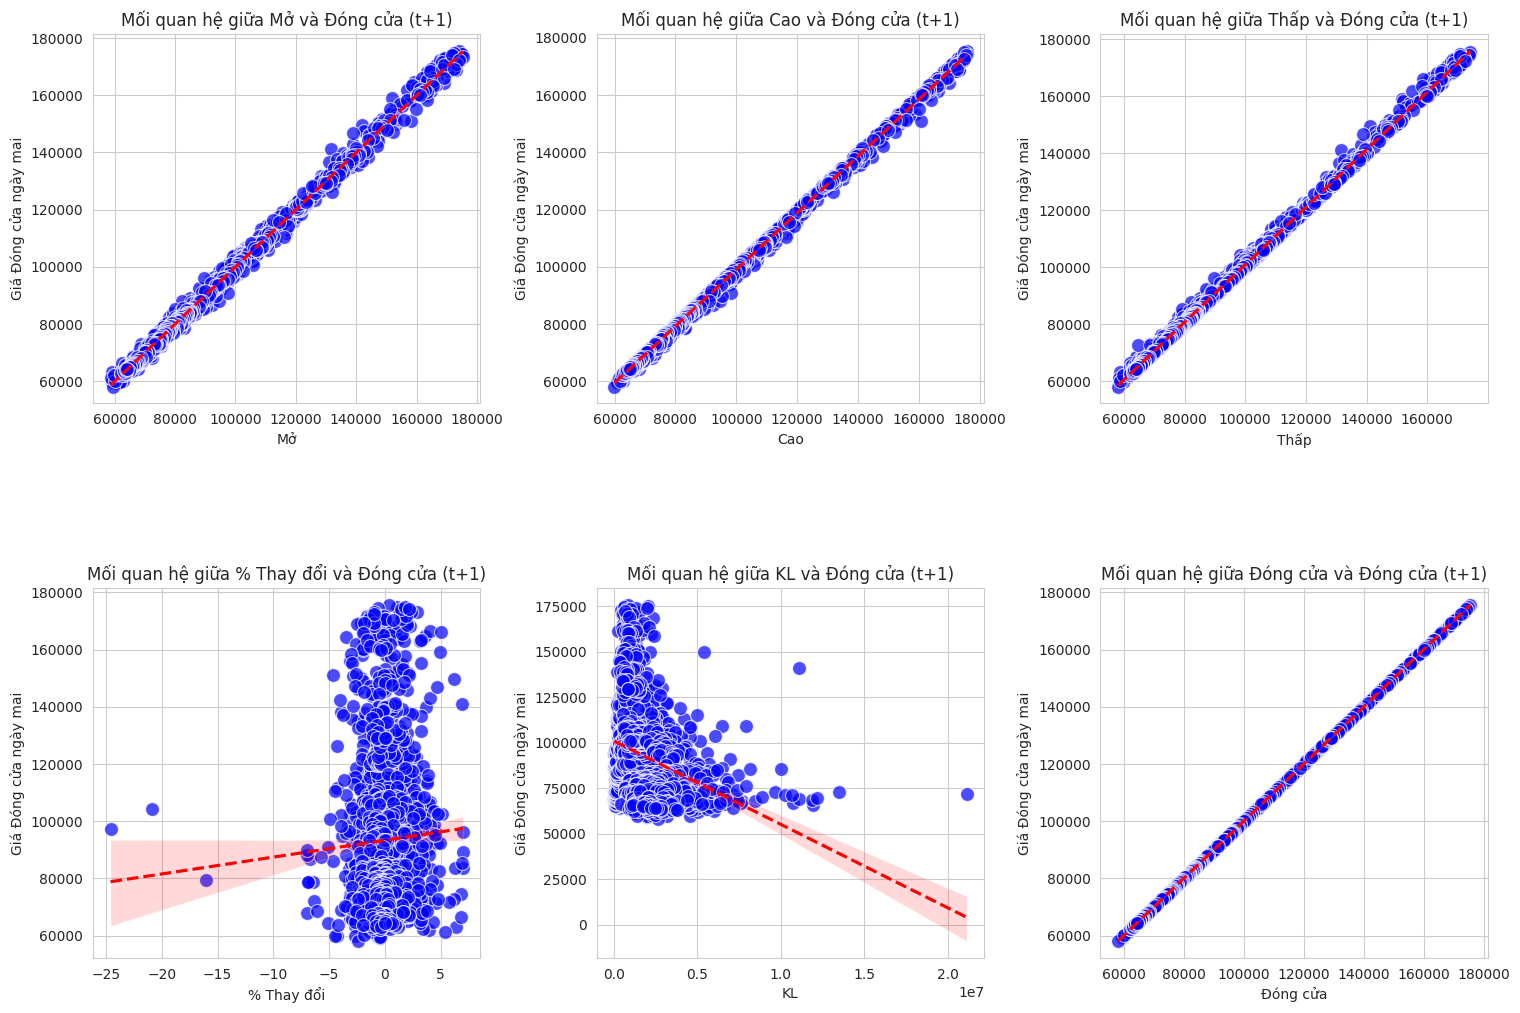

In [ ]:
def visualize_correlation(df):
    closing_price = df["Đóng cửa"]
    closng_price_t = df["Đóng cửa (t+1)"]
    open_price = df["Mở"]
    high_price = df["Cao"]
    low_price = df["Thấp"]
    volume = df["KL"]
    pct_change = df["% Thay đổi"]
    columns_to_check = [open_price, high_price, low_price, pct_change, volume, closing_price]
    column_names = ["Mở", "Cao", "Thấp", "% Thay đổi", "KL", "Đóng cửa"]
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 2 hàng, 3 cột
    axes = axes.flatten()
    for i, (col, name) in enumerate(zip(columns_to_check, column_names)):
        correlation = closing_price.corr(col)
        sns.scatterplot(x=col, y=closing_price, ax=axes[i], color="blue", s=100, alpha=0.7)
        sns.regplot(x=col, y=closing_price, scatter=False, ax=axes[i], color="red", line_kws={"linestyle": "--"})
        axes[i].set_title(f"Mối quan hệ giữa {name} và Đóng cửa (t+1)", fontsize=12)
        axes[i].set_xlabel(name, fontsize=10)
        axes[i].set_ylabel("Giá Đóng cửa ngày mai", fontsize=10)
    # axes[-1].axis('off')
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.show()

visualize_correlation(data)

Các biểu đồ scatterplot cho thấy mối quan hệ giữa các biến khác nhau với giá Đóng cửa. **Giữa Giá Mở, Giá Cao và Giá Thấp với Giá Đóng cửa có mối tương quan tuyến tính rõ ràng, cho thấy sự phản ánh gần đúng của giá Đóng cửa với các giá trị này. Tuy nhiên, biểu đồ giữa % Thay đổi và Giá Đóng cửa không tuyến tính, cho thấy sự thay đổi lớn trong giá trị % có thể không tương ứng tuyến tính với sự thay đổi của giá Đóng cửa.** Biểu đồ mối quan hệ giữa Khối lượng (KL) và Giá Đóng cửa cũng thể hiện sự tương quan nghịch tuyến tính, với sự giảm khối lượng không nhất thiết phải dẫn đến sự giảm tương ứng của giá Đóng cửa.

### **3.5. Phân tích xu hướng và biến động của giá đóng cửa**


#### ***Biểu đồ thời gian của giá Đóng cửa***


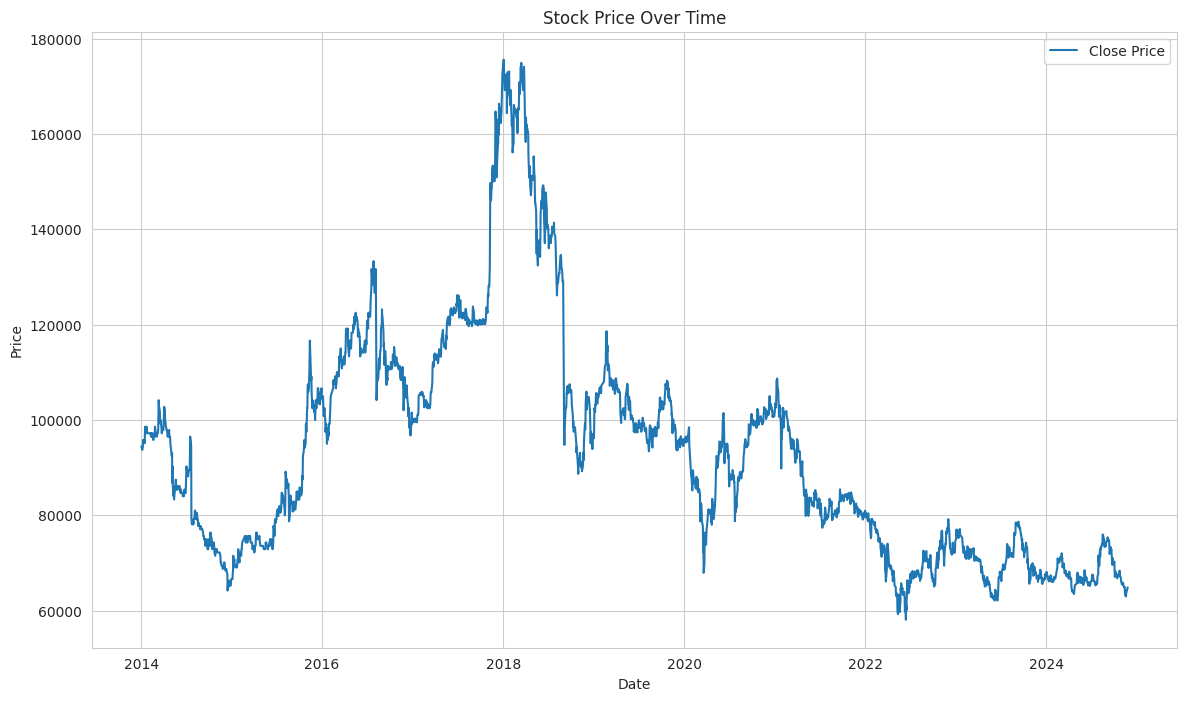

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Đọc dữ liệu
# data.index = data['Ngày']
# display(data)
close_prices = data["Đóng cửa (t+1)"]

# Vẽ biểu đồ xu hướng giá cổ phiếu
plt.figure(figsize=(14, 8))
plt.plot(data['Ngày'], close_prices, label='Close Price')
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Vẽ biểu đồ xu hướng theo từng biến
# variables = ['Đóng cửa', 'Mở', 'Cao', 'Thấp', 'KL', '% Thay đổi']
# fig, axes = plt.subplots(len(variables), 4, figsize=(20, 20))

# for i, var in enumerate(variables):
#     result = seasonal_decompose(data[var], model='additive', period=30)
#     result.observed.plot(ax=axes[i, 0], title=f'{var} - Observed')
#     result.trend.plot(ax=axes[i, 1], title=f'{var} - Trend')
#     result.seasonal.plot(ax=axes[i, 2], title=f'{var} - Seasonal')
#     result.resid.plot(ax=axes[i, 3], title=f'{var} - Residual')

# plt.tight_layout()
# plt.show()

Nhận xét:
1. Xu hướng chính:
   - Giai đoạn từ 2014 đến 2018, giá đóng cửa có xu hướng tăng mạnh, đạt đỉnh vào năm 2018.
   - Sau năm 2018, giá giảm mạnh và biến động liên tục cho đến 2024, nhưng xu hướng tổng thể là giảm dần.

2. Biến động:
   - Giai đoạn từ 2016 đến 2018 thể hiện sự tăng trưởng đột phá, nhưng cũng xuất hiện mức độ biến động lớn.
   - Từ 2020 đến 2024, giá ít biến động hơn nhưng duy trì xu hướng giảm.

3. Ý nghĩa:
   - Thị trường có dấu hiệu không ổn định và chịu ảnh hưởng lớn bởi các yếu tố kinh tế hoặc sự kiện cụ thể trong giai đoạn 2018-2020.
   - Việc giảm giá sau 2018 có thể phản ánh xu hướng suy thoái hoặc sự điều chỉnh sau giai đoạn tăng trưởng nóng.


#### ***Biểu đồ xu hướng theo nhiều chu kì***

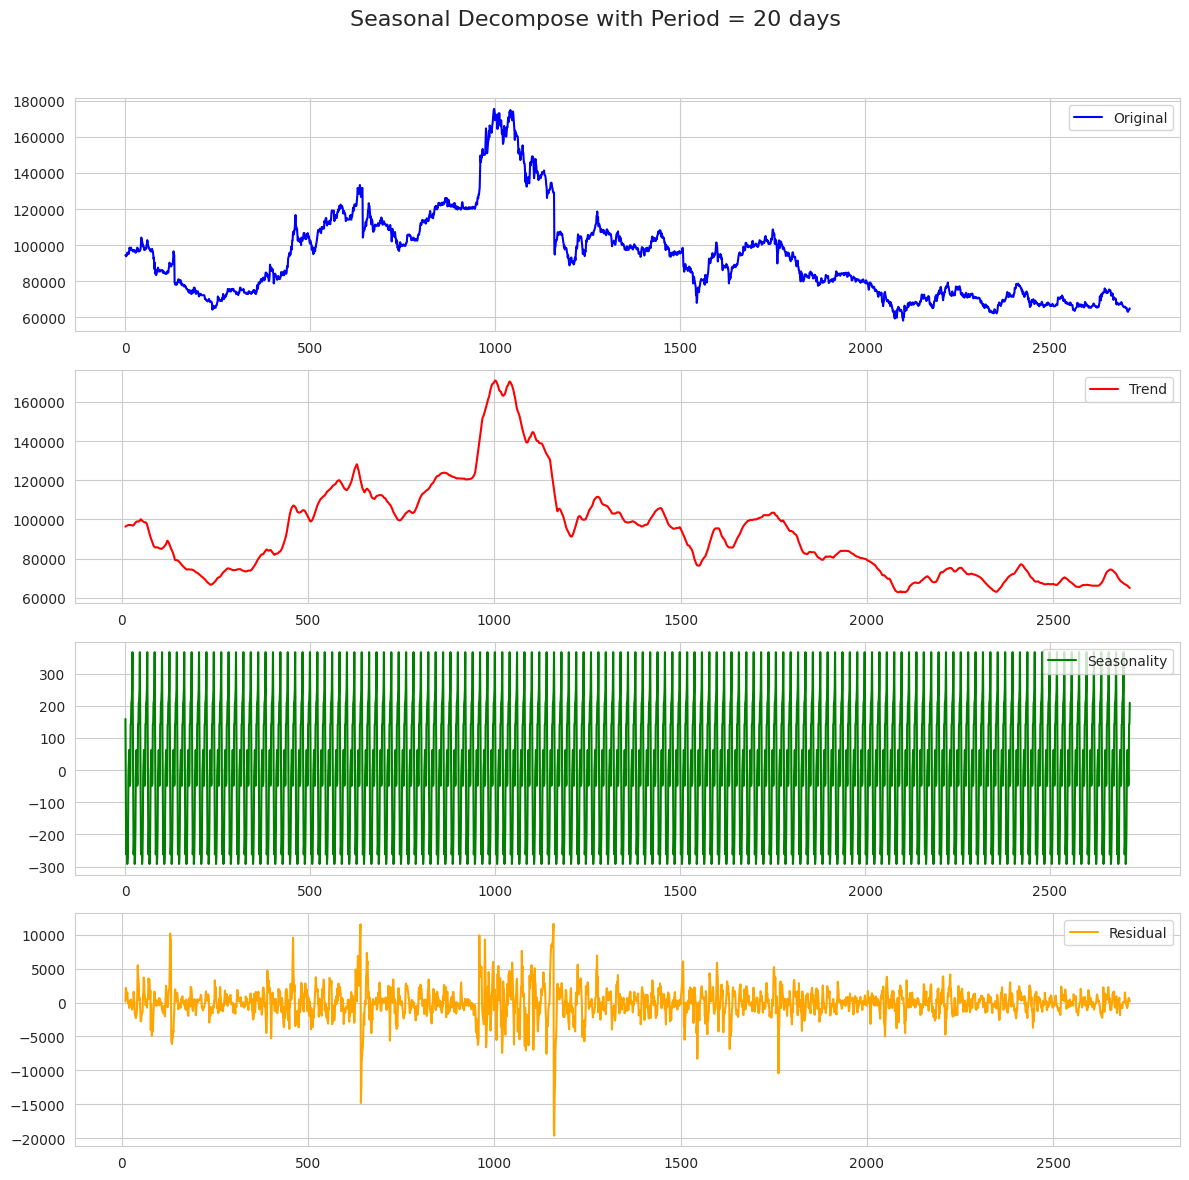

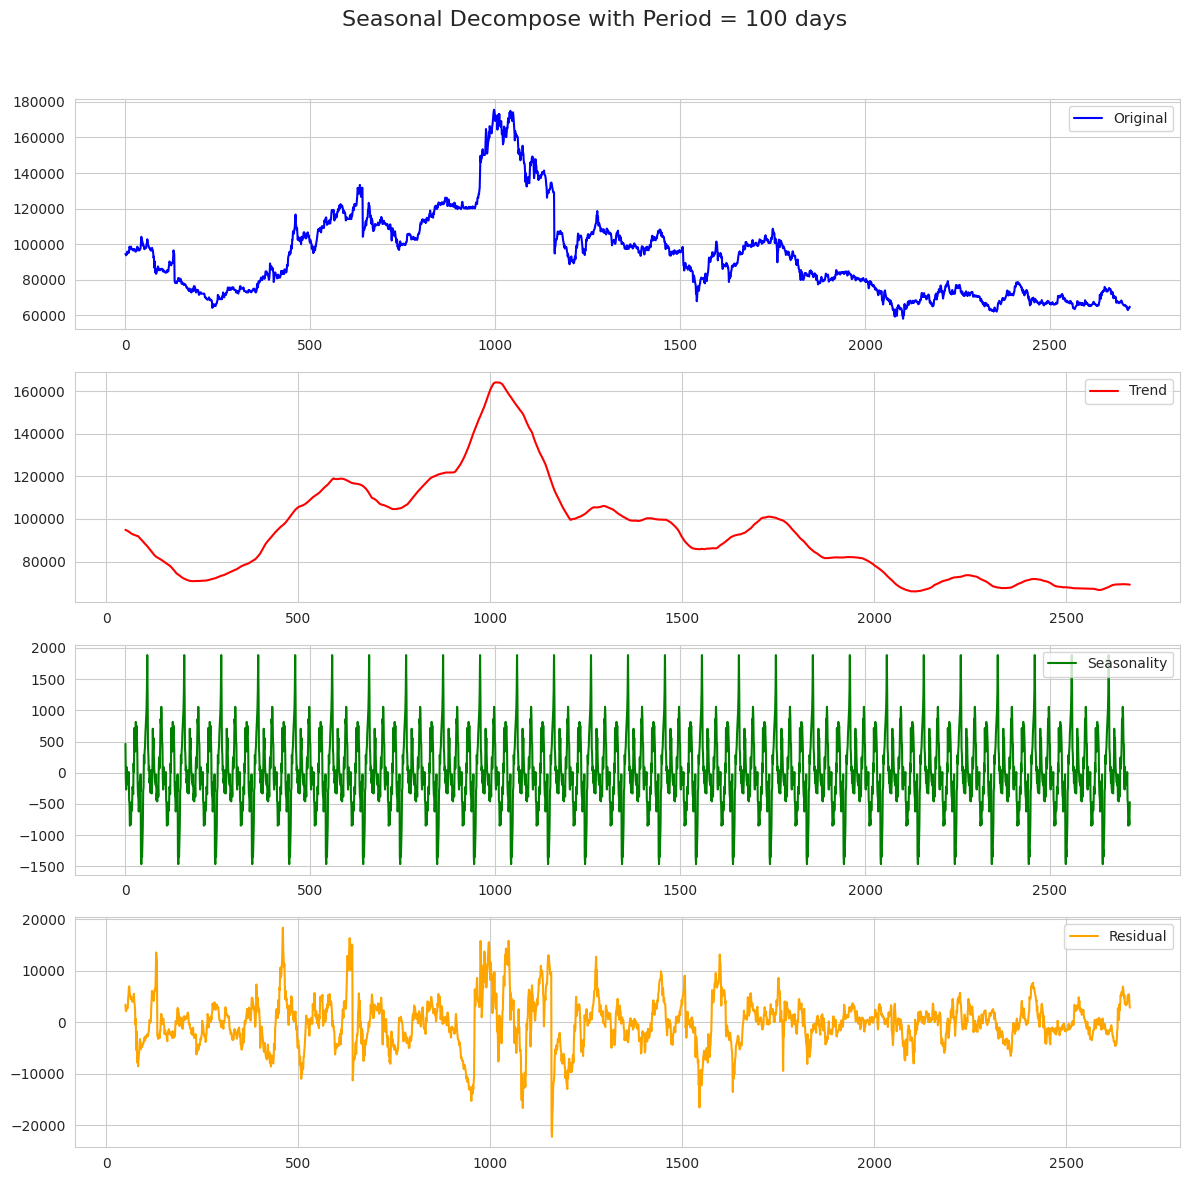

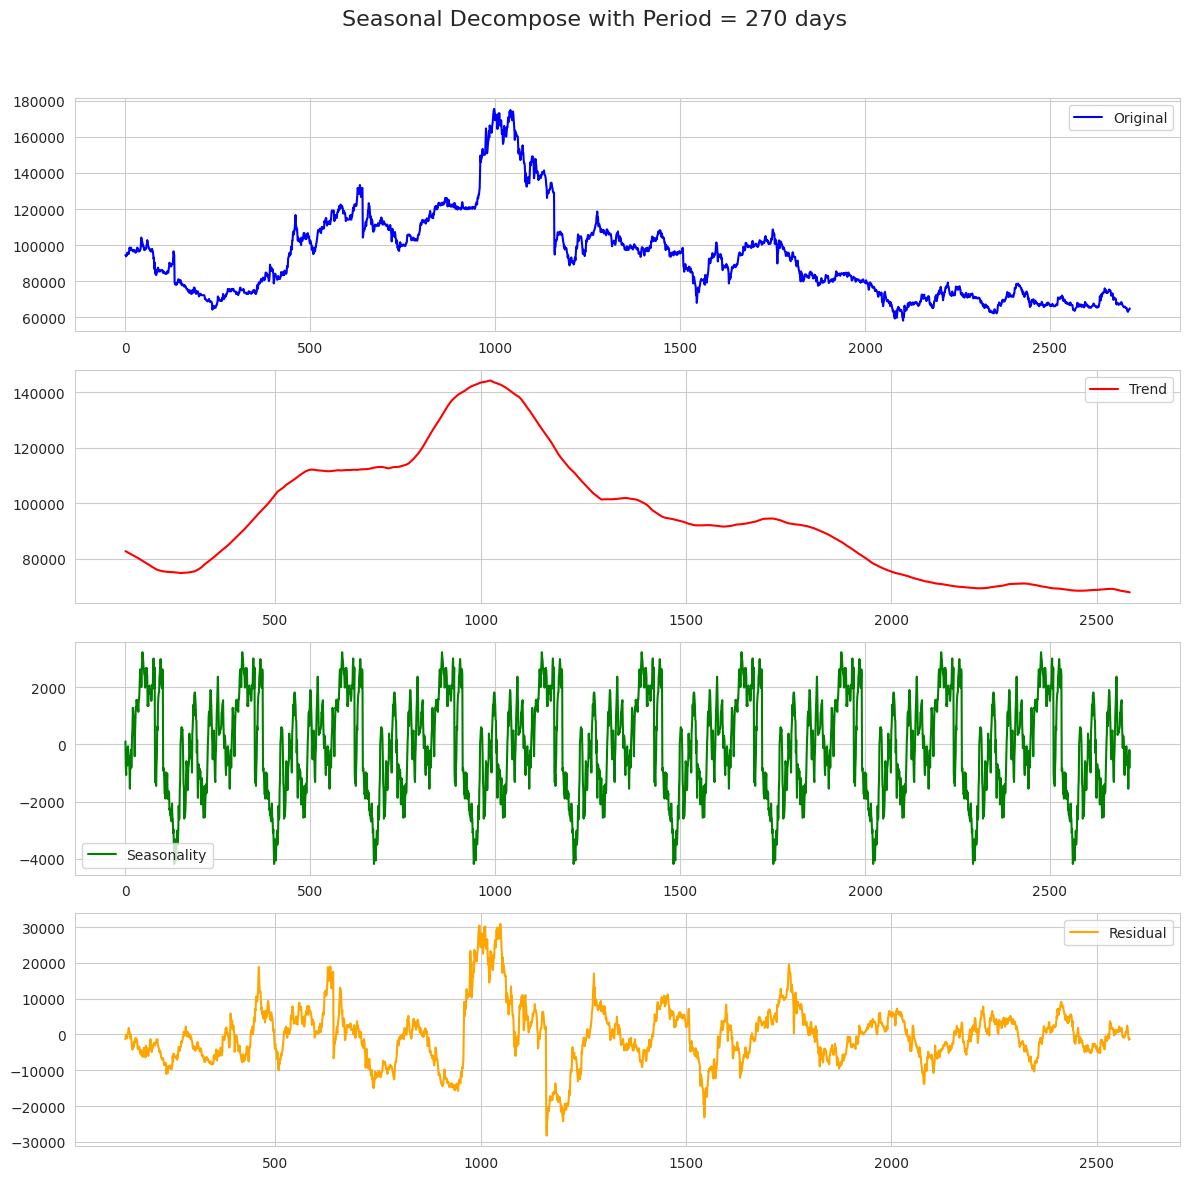

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Danh sách chu kỳ muốn thử nghiệm
series = data['Đóng cửa (t+1)'].dropna()
periods = [20, 100, 270]  # Chu kỳ 1 tháng, 1 quý, 1 năm

for period in periods:
    decomposition = seasonal_decompose(series, model='additive', period=period)     # Decompose với chu kỳ hiện tại

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(12, 12))
    plt.suptitle(f"Seasonal Decompose with Period = {period} days", fontsize=16)

    plt.subplot(411)
    plt.plot(series, label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='red')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality', color='green')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residual', color='orange')
    plt.legend(loc='best')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Chừa chỗ cho tiêu đề
    plt.show()


## **4. Mô hình hồi quy tuyến tính**


### **Chuẩn bị xây dựng mô hình**

#### ***1. Kiểm tra giả định của hồi quy tuyến tính***


In [ ]:
def check_linear_regression_assumptions(X, y):
    X_const = sm.add_constant(X)
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X_const.values, i + 1) for i in range(len(X.columns))]
    print("Variance Inflation Factor (VIF):")
    display(vif_data)

    if vif_data["VIF"].max() > 10:
        print("Phát hiện đa cộng tuyến (Multicollinearity detected).")
    else:
        print("Không có đa cộng tuyến (No multicollinearity).")

X = data[['Mở', 'Cao', 'Thấp', 'KL', 'Đóng cửa']]
y = data['Đóng cửa (t+1)']

# Kiểm tra các giả định
check_linear_regression_assumptions(X, y)

Variance Inflation Factor (VIF):


,Feature,VIF
0,Mở,1430.265451
1,Cao,1746.928718
2,Thấp,1742.954909
3,KL,1.204268
4,Đóng cửa,1647.758224


Phát hiện đa cộng tuyến (Multicollinearity detected).


Theo kết quả trên, ta có thể nhận thấy các biến Cao, Mở, Thấp, Đóng cửa có chỉ số VIF lần lượt là 1781.954090, 1771.592315, 1747.769727 và 2306.403804, vượt xa ngưỡng chấp nhận được (VIF > 10). **Điều này cho thấy các biến này có mối tương quan cực kỳ cao với nhau, gây ảnh hưởng lớn đến độ ổn định của hệ số hồi quy và tính giải thích của mô hình.** Trong khi đó, hai biến còn lại là % Thay đổi và KL có VIF thấp (lần lượt là 2.52 và 1.21), không có vấn đề về đa cộng tuyến.

#### ***2. Xử lý VIF bằng cách tạo biến Trung bình***

In [ ]:
data['Trung bình'] = (data['Cao'] + data['Thấp'] + data['Mở'] + data['Đóng cửa']) / 4
display(data)

X = data[['Trung bình', 'KL']]
y = data['Đóng cửa (t+1)']

check_linear_regression_assumptions(X, y)

,Ngày,Đóng cửa,Mở,Cao,Thấp,KL,% Thay đổi,Đóng cửa (t+1),Trung bình
0,2014-01-02,93750.0,93750.0,95139.0,93750.0,46830.0,0.00,94444.0,94097.25
1,2014-01-03,94444.0,93750.0,94444.0,93750.0,44210.0,0.74,94444.0,94097.00
2,2014-01-06,94444.0,93750.0,94444.0,93750.0,111010.0,0.00,93750.0,94097.00
3,2014-01-07,93750.0,94444.0,94444.0,93750.0,152450.0,-0.73,94444.0,94097.00
4,2014-01-08,94444.0,93750.0,94444.0,93750.0,56020.0,0.74,94444.0,94097.00
...,...,...,...,...,...,...,...,...,...
2712,2024-11-19,63000.0,63300.0,63500.0,63000.0,2830000.0,-0.32,63600.0,63200.00
2713,2024-11-20,63600.0,63000.0,63800.0,62900.0,2820000.0,0.95,63900.0,63325.00
2714,2024-11-21,63900.0,63700.0,64100.0,63400.0,2250000.0,0.47,64300.0,63775.00
2715,2024-11-22,64300.0,63900.0,64800.0,63900.0,2590000.0,0.63,64300.0,64225.00


Variance Inflation Factor (VIF):


,Feature,VIF
0,Trung bình,1.098085
1,KL,1.098085


Không có đa cộng tuyến (No multicollinearity).


#### ***Kiểm tra lại xem biến đầu mục tiêu có ảnh hưởng đến giá đóng cửa ngày mai không***

In [ ]:
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS
import pandas as pd

# Giả sử X chứa các biến có VIF cao và y chứa `Đóng cửa (t+1)`
model = LinearRegression()
model.fit(X, y)

# In hệ số mô hình và giá trị p để đánh giá ảnh hưởng của từng biến
ols_model = OLS(y, X).fit()
print(ols_model.summary())

                                 OLS Regression Results                                
Dep. Variable:         Đóng cửa (t+1)   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          3.902e+06
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                        0.00
Time:                        17:13:35   Log-Likelihood:                         -24216.
No. Observations:                2717   AIC:                                  4.844e+04
Df Residuals:                    2715   BIC:                                  4.845e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### ***3. Chuẩn hóa dữ liệu trước khi chia dữ liệu***


In [ ]:
from sklearn.preprocessing import MinMaxScaler

columns_to_use = ['KL', 'Trung bình']
scaler = MinMaxScaler()
data_scaled = data.copy()
data_scaled[columns_to_use] = scaler.fit_transform(data[columns_to_use])
display(data_scaled)

,Ngày,Đóng cửa,Mở,Cao,Thấp,KL,% Thay đổi,Đóng cửa (t+1),Trung bình
0,2014-01-02,93750.0,93750.0,95139.0,93750.0,0.000335,0.00,94444.0,0.303203
1,2014-01-03,94444.0,93750.0,94444.0,93750.0,0.000210,0.74,94444.0,0.303201
2,2014-01-06,94444.0,93750.0,94444.0,93750.0,0.003376,0.00,93750.0,0.303201
3,2014-01-07,93750.0,94444.0,94444.0,93750.0,0.005340,-0.73,94444.0,0.303201
4,2014-01-08,94444.0,93750.0,94444.0,93750.0,0.000770,0.74,94444.0,0.303201
...,...,...,...,...,...,...,...,...,...
2712,2024-11-19,63000.0,63300.0,63500.0,63000.0,0.132237,-0.32,63600.0,0.036843
2713,2024-11-20,63600.0,63000.0,63800.0,62900.0,0.131763,0.95,63900.0,0.037921
2714,2024-11-21,63900.0,63700.0,64100.0,63400.0,0.104749,0.47,64300.0,0.041800
2715,2024-11-22,64300.0,63900.0,64800.0,63900.0,0.120863,0.63,64300.0,0.045680


#### ***4. Chia dữ liệu***

In [ ]:
selected_columns = ['KL', 'Đóng cửa', 'Trung bình']

input_columns = ['KL', 'Trung bình']
output_column = 'Đóng cửa (t+1)'
date_column = 'Ngày'

# Chia dữ liệu thành tập train và test
train_len = int(len(data) * 0.8)
columns_to_use = [date_column] + selected_columns + [output_column]
train = data_scaled[columns_to_use][:train_len].copy()
test = data_scaled[columns_to_use][train_len - 1:].copy()

train_original = data[columns_to_use][:train_len].copy()
test_original = data[columns_to_use][train_len - 1:].copy()

### **Xây dựng mô hình**


#### ***1. Cross validation (giảm tình trạng overfitting)***


In [ ]:
# ### Kiểm tra Cross-validation
# from sklearn.model_selection import cross_val_score, cross_val_predict

# train_cv = train.copy()

# # Tách X và y
# X_train = train.drop([output_column, date_column], axis=1)
# y_train = train[output_column]

# # Khởi tạo mô hình hồi quy tuyến tính
# model = LinearRegression()

# # Cross-validation: tính R² cho mỗi fold
# cv_scores = cross_val_score(model, X_train, y_train, cv=7, scoring='r2')  # Sử dụng 5-fold CV
# print(f"Cross-validation R² scores: {cv_scores}")
# print(f"Mean R² score: {cv_scores.mean()}")
# print(f"Standard deviation of R² scores: {cv_scores.std()}")

# # Cross-validation: dự báo cho từng mẫu trong tập huấn luyện
# preds = cross_val_predict(model, X_train, y_train, cv=5)

# # Gán giá trị dự báo vào tập huấn luyện để kiểm tra
# train_cv['Predictions'] = preds

# # In một số giá trị dự báo
# display(train_cv[['Đóng cửa (t+1)', 'Predictions']].head())


In [ ]:
# from sklearn.model_selection import cross_validate

# cv_results = cross_validate(model, X_train, y_train, cv= 7, return_estimator=True)
# print('Mean score: ',cv_results['test_score'].mean())
# print(cv_results)

In [ ]:
# test_cv = test.copy()
# test_cv = test_cv.dropna()

# # Tách X và y cho tập test
# X_test = test_cv.drop([output_column, date_column], axis=1)
# y_test = test_cv[output_column]

# # Huấn luyện mô hình trên toàn bộ tập train
# model.fit(X_train, y_train)

# # Dự báo trên tập test
# y_pred_test = model.predict(X_test)
# test_cv['Predictions'] = y_pred_test
# test_cv = test_cv.dropna()

# test_scores =[]
# for i in range(len(cv_results['estimator'])):
#     score = cv_results['estimator'][i].score(X_test,y_test) # Calculate the score
#     test_scores.append(round(score, 5)) # Round the score and append it to the list

# print(test_scores)
# # Đánh giá hiệu năng trên tập test
# r2 = r2_score(y_test, y_pred_test)
# mae = mean_absolute_error(y_test, y_pred_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# print("\nKiểm định trên tập test:")
# print(f"R² (R-squared): {r2}")
# print(f"Mean Absolute Error (MAE): {mae}")
# print(f"Root Mean Squared Error (RMSE): {rmse}")

# # Gắn giá trị dự báo vào tập test
# # In một số giá trị thực tế và dự báo
# print("\nGiá trị thực tế và dự báo (một vài mẫu):")
# display(test_cv[['Ngày', 'Đóng cửa', 'Predictions']].head())


#### ***2. Lasso***


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

def train_and_predict_Lasso(train, test, output_column, date_column):
    # Tách X và y cho train
    X_train = train.drop([output_column, date_column], axis=1)
    y_train = train[output_column]

    # Khởi tạo Lasso
    model = Lasso()

    # Thiết lập GridSearchCV với các giá trị alpha khác nhau
    param_grid = {'alpha': [0.01, 0.1, 0.5, 1, 10, 100]}  # Giá trị `alpha` có thể điều chỉnh tùy theo ứng dụng
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')  # Sử dụng 5-fold CV

    # Huấn luyện GridSearchCV
    grid_search.fit(X_train, y_train)

    # In ra giá trị `alpha` tốt nhất
    best_alpha = grid_search.best_params_['alpha']
    print(f"Tối ưu alpha: {best_alpha}")

    # Tách X và y cho test
    test_ls = test.copy()
    train_ls = train.copy()
    X_test = test_ls.drop([output_column, date_column], axis=1)
    y_test = test_ls[output_column]

    # Giá trị `alpha` càng lớn, regularization càng mạnh
    model = Lasso(alpha=best_alpha)

    # Huấn luyện mô hình
    model.fit(X_train, y_train)

    # Dự đoán trên tập train
    preds_train = model.predict(X_train)
    train_ls['Predicted'] = preds_train

    # Dự đoán trên tập test
    preds_test = model.predict(X_test)
    test_ls['Predicted'] = preds_test

    return train_ls, test_ls


In [ ]:
def evaluate_and_plot(data, output_column, name):
    data = data.dropna()
    # Tính các chỉ số đánh giá trên tập dữ liệu
    mse = mean_squared_error(data[output_column], data['Predicted'])
    r2 = r2_score(data[output_column], data['Predicted'])
    mae = mean_absolute_error(data[output_column], data['Predicted'])
    rmse = mse ** 0.5
    mape = mean_absolute_percentage_error(data[output_column], data['Predicted'])

    # Tạo DataFrame để hiển thị các chỉ số đánh giá
    metrics_df = pd.DataFrame({
        'Metrics': ['R²', 'MAE', 'MSE', 'RMSE', 'MAPE'],
        'Values': [r2, mae, mse, rmse, mape]
    })
    metrics_df['Values'] = metrics_df['Values'].map('{:.4f}'.format)
    display(metrics_df)

    # Vẽ đồ thị so sánh Actual vs Predicted
    plt.figure(figsize=(20, 10))
    sns.set_style("whitegrid")
    plt.plot(data['Ngày'], data[output_column], label='Actual', color='blue')
    plt.plot(data['Ngày'], data['Predicted'], label='Predicted', color='orange')
    plt.title(f"{output_column} - {name}", fontsize=20, pad=20)
    plt.xlabel('Thời gian', fontsize=18, labelpad=20)
    plt.ylabel(output_column, fontsize=15, labelpad=20)
    plt.legend()
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.181e+09, tolerance: 9.566e+07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.695e+09, tolerance: 1.072e+08
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.048e+09, tolerance: 4.272e

Tối ưu alpha: 10


,Metrics,Values
0,R²,0.9447
1,MAE,658.4845
2,MSE,795893.4621
3,RMSE,892.1286
4,MAPE,0.0094


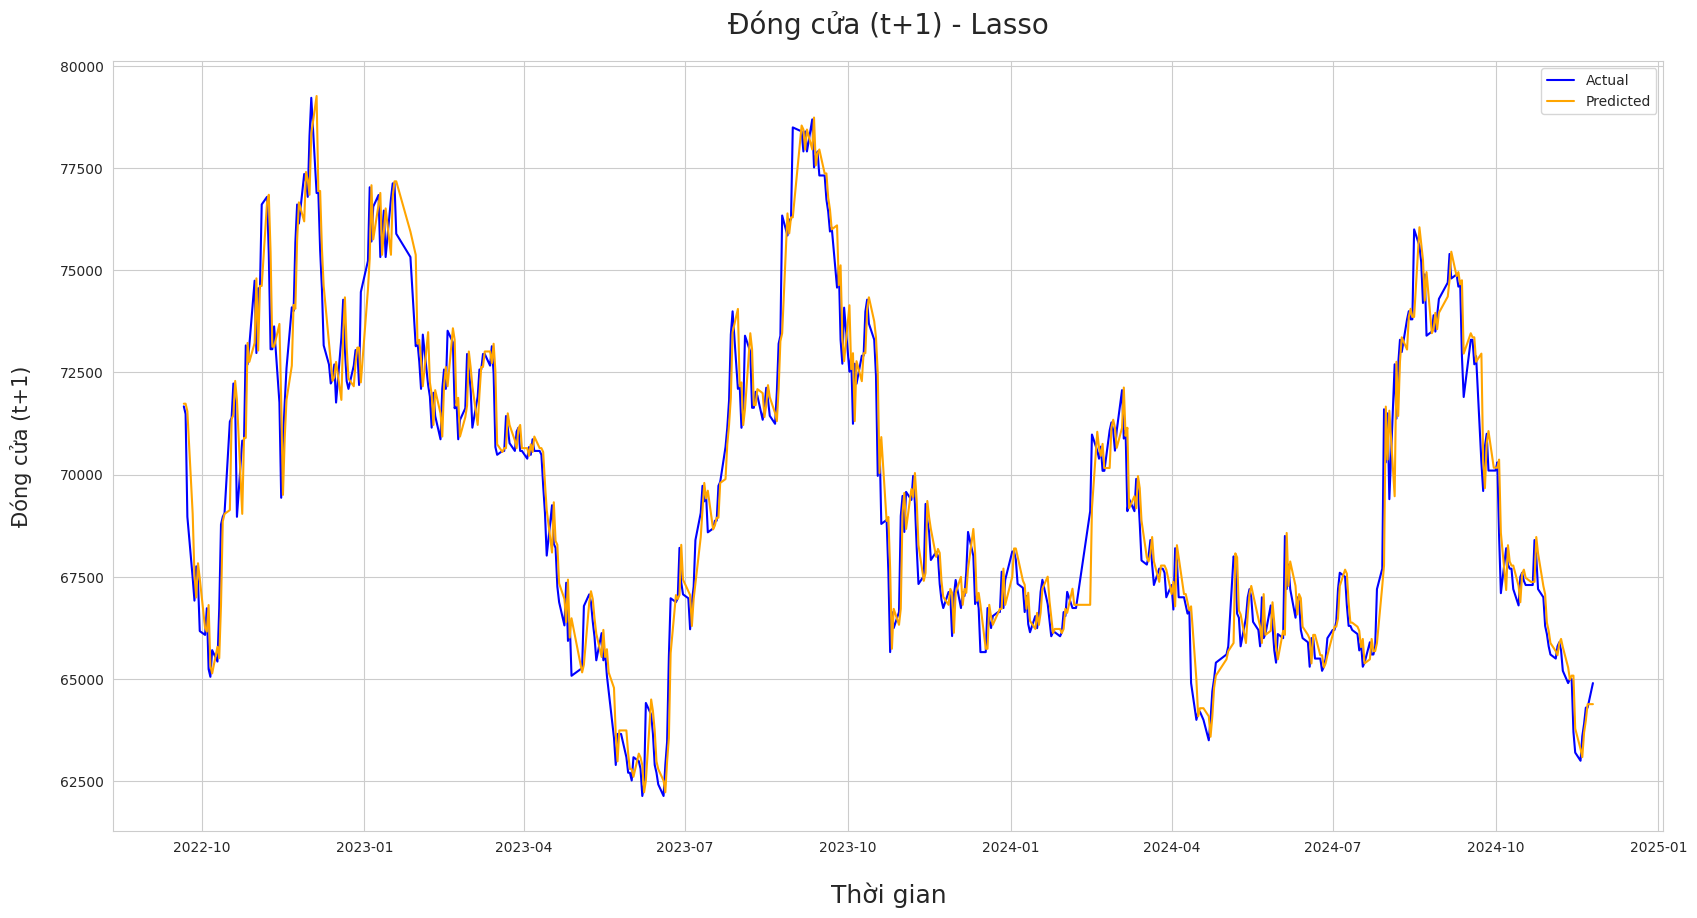

In [ ]:
train_ls, test_ls = train_and_predict_Lasso(train, test, output_column, date_column)
evaluate_and_plot(test_ls, output_column, 'Lasso')

#### ***3. Mô hình hồi quy tuyến tính***

,Ngày,KL,Đóng cửa,Trung bình,Đóng cửa (t+1)
0,2014-01-02,0.000335,93750.0,0.303203,94444.0
1,2014-01-03,0.000210,94444.0,0.303201,94444.0
2,2014-01-06,0.003376,94444.0,0.303201,93750.0
3,2014-01-07,0.005340,93750.0,0.303201,94444.0
4,2014-01-08,0.000770,94444.0,0.303201,94444.0
...,...,...,...,...,...
2168,2022-09-15,0.055461,69434.1,0.090385,70832.1
2169,2022-09-16,0.107593,70832.1,0.096813,70086.5
2170,2022-09-19,0.065413,70086.5,0.097416,70645.7
2171,2022-09-20,0.052143,70645.7,0.099826,71670.9


,Ngày,KL,Đóng cửa,Trung bình,Đóng cửa (t+1)
2172,2022-09-21,0.115649,71670.9,0.106254,71670.9
2173,2022-09-22,0.046930,71670.9,0.107861,71484.5
2174,2022-09-23,0.064465,71484.5,0.109668,68968.1
2175,2022-09-26,0.158777,68968.1,0.094001,67476.9
2176,2022-09-27,0.112806,67476.9,0.082753,66917.7
...,...,...,...,...,...
2712,2024-11-19,0.132237,63000.0,0.036843,63600.0
2713,2024-11-20,0.131763,63600.0,0.037921,63900.0
2714,2024-11-21,0.104749,63900.0,0.041800,64300.0
2715,2024-11-22,0.120863,64300.0,0.045680,64300.0


,Ngày,Đóng cửa,Đóng cửa (t+1),Predicted
2172,2022-09-21,71670.9,71670.9,71342.267690
2173,2022-09-22,71670.9,71484.5,71447.678222
2174,2022-09-23,71484.5,68968.1,71677.619872
2175,2022-09-26,68968.1,67476.9,69973.948411
2176,2022-09-27,67476.9,66917.7,68617.328712
...,...,...,...,...
2712,2024-11-19,63000.0,63600.0,63323.532055
2713,2024-11-20,63600.0,63900.0,63447.769309
2714,2024-11-21,63900.0,64300.0,63865.310264
2715,2024-11-22,64300.0,64300.0,64333.486006


,Metrics,Values
0,R²,0.9337
1,MAE,748.2008
2,MSE,955060.3298
3,RMSE,977.2719
4,MAPE,0.0107


'Giá đóng cửa dự kiến ngày mai 2024-11-26 sẽ cao hơn so với ngày hiện tại.'

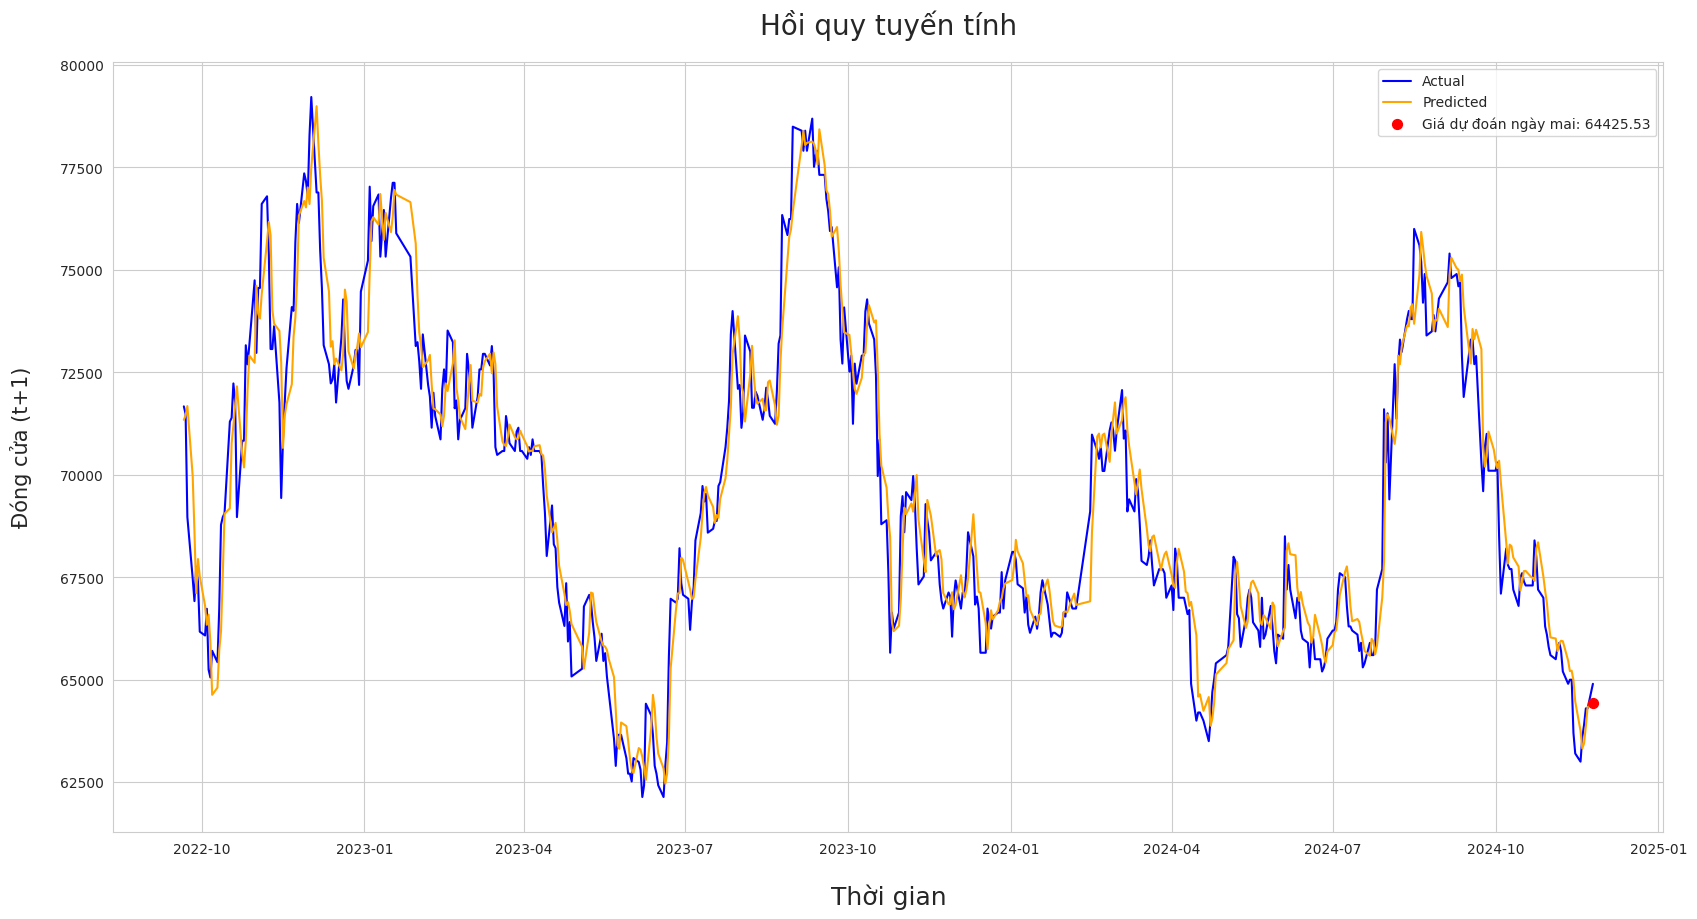

In [ ]:
# Hàm xây dựng và lưu mô hình
def train_and_predict_linear_regression(train, test, input_columns, output_column):
    test_linear = test.copy()
    train_linear = train.copy()
    display(train_linear, test_linear)

    # Tách X và y
    X_train = train_linear[input_columns]
    y_train = train_linear[output_column]
    X_test = test_linear[input_columns]
    y_test = test_linear[output_column]

    # Tạo mô hình Linear Regression
    model = LinearRegression()
    model.fit(X_train, y_train)

     # Dự đoán
    y_preds = model.predict(X_test)
    test_linear['Predicted'] = y_preds

    # Hiển thị kết quả
    display(test_linear[['Ngày','Đóng cửa', output_column, 'Predicted']])

    # Lưu dữ liệu dự đoán của dòng cuối cùng
    last_predicted = test_linear.iloc[-1]
    last_predicted_value = last_predicted['Predicted']

    # Tính các chỉ số đánh giá
    mae = mean_absolute_error(test_linear[output_column], test_linear['Predicted'])
    mse = mean_squared_error(test_linear[output_column], test_linear['Predicted'])
    mape = mean_absolute_percentage_error(test_linear[output_column], test_linear['Predicted'])
    rmse = mse ** 0.5
    r2 = r2_score(test_linear[output_column], test_linear['Predicted'])

    metrics_df = pd.DataFrame({
        'Metrics': ['R²', 'MAE', 'MSE', 'RMSE', 'MAPE'],
        'Values': [r2, mae, mse, rmse, mape]
    })
    metrics_df['Values'] = metrics_df['Values'].map('{:.4f}'.format)
    display(metrics_df)

    # Lấy ngày tiếp theo
    next_day = last_predicted['Ngày'].date() + pd.Timedelta(days=1)

    # Lấy giá trị Đóng cửa hiện tại và Predicted cho ngày tiếp theo
    closing_price = last_predicted['Đóng cửa']
    predicted_price = last_predicted['Predicted']

    # So sánh và in ra kết quả
    if predicted_price > closing_price:
        display(f'Giá đóng cửa dự kiến ngày mai {next_day} sẽ cao hơn so với ngày hiện tại.')
    else:
        display(f'Giá đóng cửa dự kiến ngày mai {next_day} sẽ thấp hơn so với ngày hiện tại.')

    # Vẽ đồ thị giá thực tế và dự đoán
    plt.figure(figsize=(20, 10))
    sns.set_style("whitegrid")
    plt.plot(test_linear['Ngày'], test_linear[output_column], label='Actual', color='blue')
    plt.plot(test_linear['Ngày'], test_linear['Predicted'], label='Predicted', color='orange')
    plt.scatter(last_predicted[date_column], last_predicted_value, color='red', s=50, label=f'Giá dự đoán ngày mai: {last_predicted_value:.2f}', zorder=2)
    plt.title(f"Hồi quy tuyến tính", fontsize=20, pad=20)
    plt.xlabel('Thời gian', fontsize=18, labelpad=20)
    plt.ylabel(output_column, fontsize=15, labelpad=20)
    plt.legend()
    plt.show()

    return test_linear

# Gọi hàm với dữ liệu
test_linear = train_and_predict_linear_regression(train, test, input_columns, output_column)


In [ ]:
# Tạo cột thay đổi giá thực tế
test_linear['Real_Change'] = np.where(test_linear['Đóng cửa (t+1)'] > test_linear['Đóng cửa'], 1,
                                        np.where(test_linear['Đóng cửa (t+1)'] < test_linear['Đóng cửa'], -1, 0))

# Tạo cột thay đổi giá dự đoán
test_linear['Predicted_Change'] = np.where(test_linear['Predicted'] > test_linear['Đóng cửa'], 1,
                                             np.where(test_linear['Predicted'] < test_linear['Đóng cửa'], -1, 0))

# Đếm số ngày có giá trị tương đồng
matching_days = (test_linear['Real_Change'] == test_linear['Predicted_Change']).sum()

# Tính tỷ lệ dự đoán đúng
matching_ratio = matching_days / len(test_linear)

# Hiển thị kết quả
print(f"Số ngày giá thực tế và giá dự đoán giống nhau: {matching_days} ngày")
print(f"Tỷ lệ dự đoán đúng: {matching_ratio:.2%}")

# Hiển thị thông tin chi tiết
test_linear[['Ngày', 'Real_Change', 'Predicted_Change']]
display(test_linear)

Số ngày giá thực tế và giá dự đoán giống nhau: 254 ngày
Tỷ lệ dự đoán đúng: 46.61%


,Ngày,KL,Đóng cửa,Trung bình,Đóng cửa (t+1),Predicted,Real_Change,Predicted_Change
2172,2022-09-21,0.115649,71670.9,0.106254,71670.9,71342.267690,0,-1
2173,2022-09-22,0.046930,71670.9,0.107861,71484.5,71447.678222,-1,-1
2174,2022-09-23,0.064465,71484.5,0.109668,68968.1,71677.619872,-1,1
2175,2022-09-26,0.158777,68968.1,0.094001,67476.9,69973.948411,-1,1
2176,2022-09-27,0.112806,67476.9,0.082753,66917.7,68617.328712,-1,1
...,...,...,...,...,...,...,...,...
2712,2024-11-19,0.132237,63000.0,0.036843,63600.0,63323.532055,1,1
2713,2024-11-20,0.131763,63600.0,0.037921,63900.0,63447.769309,1,-1
2714,2024-11-21,0.104749,63900.0,0.041800,64300.0,63865.310264,1,-1
2715,2024-11-22,0.120863,64300.0,0.045680,64300.0,64333.486006,0,1


###

#### Xác định tín hiệu mua bán

<ipython-input-398-83c7341c74f2>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_linear_filtered['RSI'] = calculate_rsi(test_linear_filtered['Predicted'])
<ipython-input-398-83c7341c74f2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_linear_filtered['MACD'], test_linear_filtered['Signal'] = calculate_macd(test_linear_filtered['Predicted'])
<ipython-input-398-83c7341c74f2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

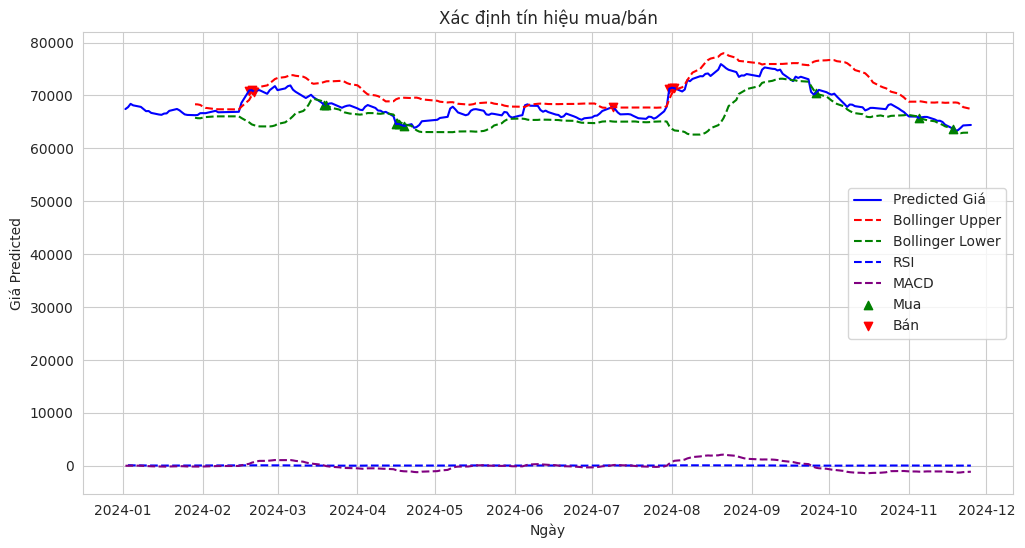

In [ ]:
# Tính chỉ số RSI

# Lọc dữ liệu từ tháng 6-2024 đến hết
test_linear_filtered = test_linear[(test_linear['Ngày'] >= '2024-01-01') & (test_linear['Ngày'] <= '2024-12-31')]

# Tính chỉ số RSI cho dữ liệu đã lọc
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

test_linear_filtered['RSI'] = calculate_rsi(test_linear_filtered['Predicted'])

# Tính chỉ số MACD
def calculate_macd(data, fast_window=12, slow_window=26, signal_window=9):
    ema_fast = data.ewm(span=fast_window, min_periods=1).mean()
    ema_slow = data.ewm(span=slow_window, min_periods=1).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal_window, min_periods=1).mean()
    return macd_line, signal_line

test_linear_filtered['MACD'], test_linear_filtered['Signal'] = calculate_macd(test_linear_filtered['Predicted'])

# Tính chỉ số Bollinger Bands
def calculate_bollinger_bands(data, window=20, num_std=2):
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    bollinger_upper = rolling_mean + (rolling_std * num_std)
    bollinger_lower = rolling_mean - (rolling_std * num_std)
    return bollinger_upper, bollinger_lower

test_linear_filtered['Bollinger Upper'], test_linear_filtered['Bollinger Lower'] = calculate_bollinger_bands(test_linear_filtered['Predicted'])

# Xác định tín hiệu mua/bán
def determine_signal(row):
    if row['RSI'] < 30 and row['Predicted'] < row['Bollinger Lower']:
        return 'Mua'
    elif row['RSI'] > 70 and row['Predicted'] > row['Bollinger Upper']:
        return 'Bán'
    else:
        return 'Giữ'

test_linear_filtered['Signal'] = test_linear_filtered.apply(determine_signal, axis=1)

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))

# Vẽ giá 'Predicted'
plt.plot(test_linear_filtered['Ngày'], test_linear_filtered['Predicted'], label='Predicted Giá', color='blue')

# Vẽ Bollinger Bands
plt.plot(test_linear_filtered['Ngày'], test_linear_filtered['Bollinger Upper'], label='Bollinger Upper', linestyle='--', color='red')
plt.plot(test_linear_filtered['Ngày'], test_linear_filtered['Bollinger Lower'], label='Bollinger Lower', linestyle='--', color='green')

# Vẽ chỉ số RSI
plt.plot(test_linear_filtered['Ngày'], test_linear_filtered['RSI'], label='RSI', linestyle='--', color='blue')

# Vẽ chỉ số MACD và Signal
plt.plot(test_linear_filtered['Ngày'], test_linear_filtered['MACD'], label='MACD', linestyle='--', color='purple')

# Thêm dấu hiệu mua và bán
plt.scatter(test_linear_filtered[test_linear_filtered['Signal'] == 'Mua']['Ngày'], test_linear_filtered[test_linear_filtered['Signal'] == 'Mua']['Predicted'], color='green', label='Mua', marker='^')
plt.scatter(test_linear_filtered[test_linear_filtered['Signal'] == 'Bán']['Ngày'], test_linear_filtered[test_linear_filtered['Signal'] == 'Bán']['Predicted'], color='red', label='Bán', marker='v')

plt.legend()
plt.title('Xác định tín hiệu mua/bán')
plt.xlabel('Ngày')
plt.ylabel('Giá Predicted')
plt.show()


Trong đoạn mã xác định tín hiệu mua, bán hoặc giữ, ba chỉ số kỹ thuật quan trọng được sử dụng để đánh giá tình trạng của thị trường cổ phiếu và đưa ra quyết định đầu tư:

- RSI (Relative Strength Index - Chỉ số sức mạnh tương đối):

Ý nghĩa: RSI đo lường mức độ quá mua hoặc quá bán của cổ phiếu. Nó có giá trị từ 0 đến 100, với ngưỡng 30 và 70 thường được sử dụng làm mốc để xác định tình trạng của cổ phiếu. Khi RSI dưới 30, nó có thể cho thấy cổ phiếu đang quá bán (oversold), và nhà đầu tư có thể xem xét việc mua vào. Ngược lại, khi RSI trên 70, cổ phiếu có thể đang quá mua (overbought), và nhà đầu tư có thể xem xét việc bán ra.
Áp dụng: Trong đoạn mã, nếu RSI < 30 và giá đóng cửa thấp hơn Bollinger Lower, tín hiệu được xác định là 'Mua'. Điều này có nghĩa là cổ phiếu đang bị bán quá mức và có thể tăng giá trong tương lai.
- Bollinger Bands (Dải Bollinger):

Ý nghĩa: Bollinger Bands gồm một đường trung bình di động (SMA) và hai dải (upper và lower) cách xa đường trung bình theo một số lần độ lệch chuẩn. Khi giá đóng cửa gần Bollinger Lower, cổ phiếu có thể đang bị bán quá mức và tín hiệu 'Mua' có thể được xác định. Ngược lại, nếu giá đóng cửa gần Bollinger Upper, cổ phiếu có thể đang quá mua và tín hiệu 'Bán' có thể được xác định.
Áp dụng: Khi RSI dưới 30 và giá đóng cửa dưới Bollinger Lower, điều này cho thấy cổ phiếu có thể đang bị bán quá mức, do đó tín hiệu được xác định là 'Mua'.
- MACD (Moving Average Convergence Divergence - Phân kỳ hội tụ trung bình di động):

Ý nghĩa: MACD đo lường mối quan hệ giữa hai đường trung bình di động ngắn hạn và dài hạn của giá cổ phiếu. Khi MACD cắt lên trên đường tín hiệu, đây có thể là tín hiệu mua. Khi MACD cắt xuống dưới đường tín hiệu, đó có thể là tín hiệu bán.
Áp dụng: Trong đoạn mã, MACD và đường tín hiệu giúp xác định xu hướng của giá cổ phiếu và cung cấp tín hiệu giao dịch bổ sung.
- Tín hiệu: Dựa trên ba chỉ số trên, một loạt các điều kiện được đặt ra để xác định tín hiệu cuối cùng:

  - Nếu RSI dưới 30 và giá đóng cửa dưới Bollinger Lower, tín hiệu là 'Mua'.
  - Nếu RSI trên 70 và giá đóng cửa trên Bollinger Upper, tín hiệu là 'Bán'.
  - Nếu không đáp ứng các điều kiện trên, tín hiệu là 'Giữ'.


#### ***4. XGBOOST***


#### ***Chọn các chỉ số phù hợp cho mô hình***

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Định nghĩa tham số
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Khởi tạo mô hình
xgb = XGBRegressor()

# Grid Search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)
X_train = train[input_columns]    # Tách X và y
y_train = train[output_column]
grid_search.fit(X_train, y_train)

# In kết quả tốt nhất
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

# Huấn luyện mô hình với tham số tối ưu
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best Score: 3384.7137140556533


#### ***Mô hình XGBOOST***

,Ngày,KL,Đóng cửa,Trung bình,Đóng cửa (t+1)
0,2014-01-02,0.000335,93750.0,0.303203,94444.0
1,2014-01-03,0.000210,94444.0,0.303201,94444.0
2,2014-01-06,0.003376,94444.0,0.303201,93750.0
3,2014-01-07,0.005340,93750.0,0.303201,94444.0
4,2014-01-08,0.000770,94444.0,0.303201,94444.0
...,...,...,...,...,...
2168,2022-09-15,0.055461,69434.1,0.090385,70832.1
2169,2022-09-16,0.107593,70832.1,0.096813,70086.5
2170,2022-09-19,0.065413,70086.5,0.097416,70645.7
2171,2022-09-20,0.052143,70645.7,0.099826,71670.9


,Ngày,KL,Đóng cửa,Trung bình,Đóng cửa (t+1)
2172,2022-09-21,0.115649,71670.9,0.106254,71670.9
2173,2022-09-22,0.046930,71670.9,0.107861,71484.5
2174,2022-09-23,0.064465,71484.5,0.109668,68968.1
2175,2022-09-26,0.158777,68968.1,0.094001,67476.9
2176,2022-09-27,0.112806,67476.9,0.082753,66917.7
...,...,...,...,...,...
2712,2024-11-19,0.132237,63000.0,0.036843,63600.0
2713,2024-11-20,0.131763,63600.0,0.037921,63900.0
2714,2024-11-21,0.104749,63900.0,0.041800,64300.0
2715,2024-11-22,0.120863,64300.0,0.045680,64300.0


,Ngày,Đóng cửa,Đóng cửa (t+1),Predicted
2172,2022-09-21,71670.9,71670.9,70885.312500
2173,2022-09-22,71670.9,71484.5,70989.875000
2174,2022-09-23,71484.5,68968.1,71737.625000
2175,2022-09-26,68968.1,67476.9,69978.515625
2176,2022-09-27,67476.9,66917.7,68616.531250
...,...,...,...,...
2712,2024-11-19,63000.0,63600.0,61555.210938
2713,2024-11-20,63600.0,63900.0,61383.988281
2714,2024-11-21,63900.0,64300.0,63574.246094
2715,2024-11-22,64300.0,64300.0,64307.503906


,Metrics,Values
0,R²,0.8928
1,MAE,922.4586
2,MSE,1542938.8583
3,RMSE,1242.1509
4,MAPE,0.0133


'Giá đóng cửa dự kiến ngày mai 2024-11-26 sẽ cao hơn so với ngày hiện tại.'

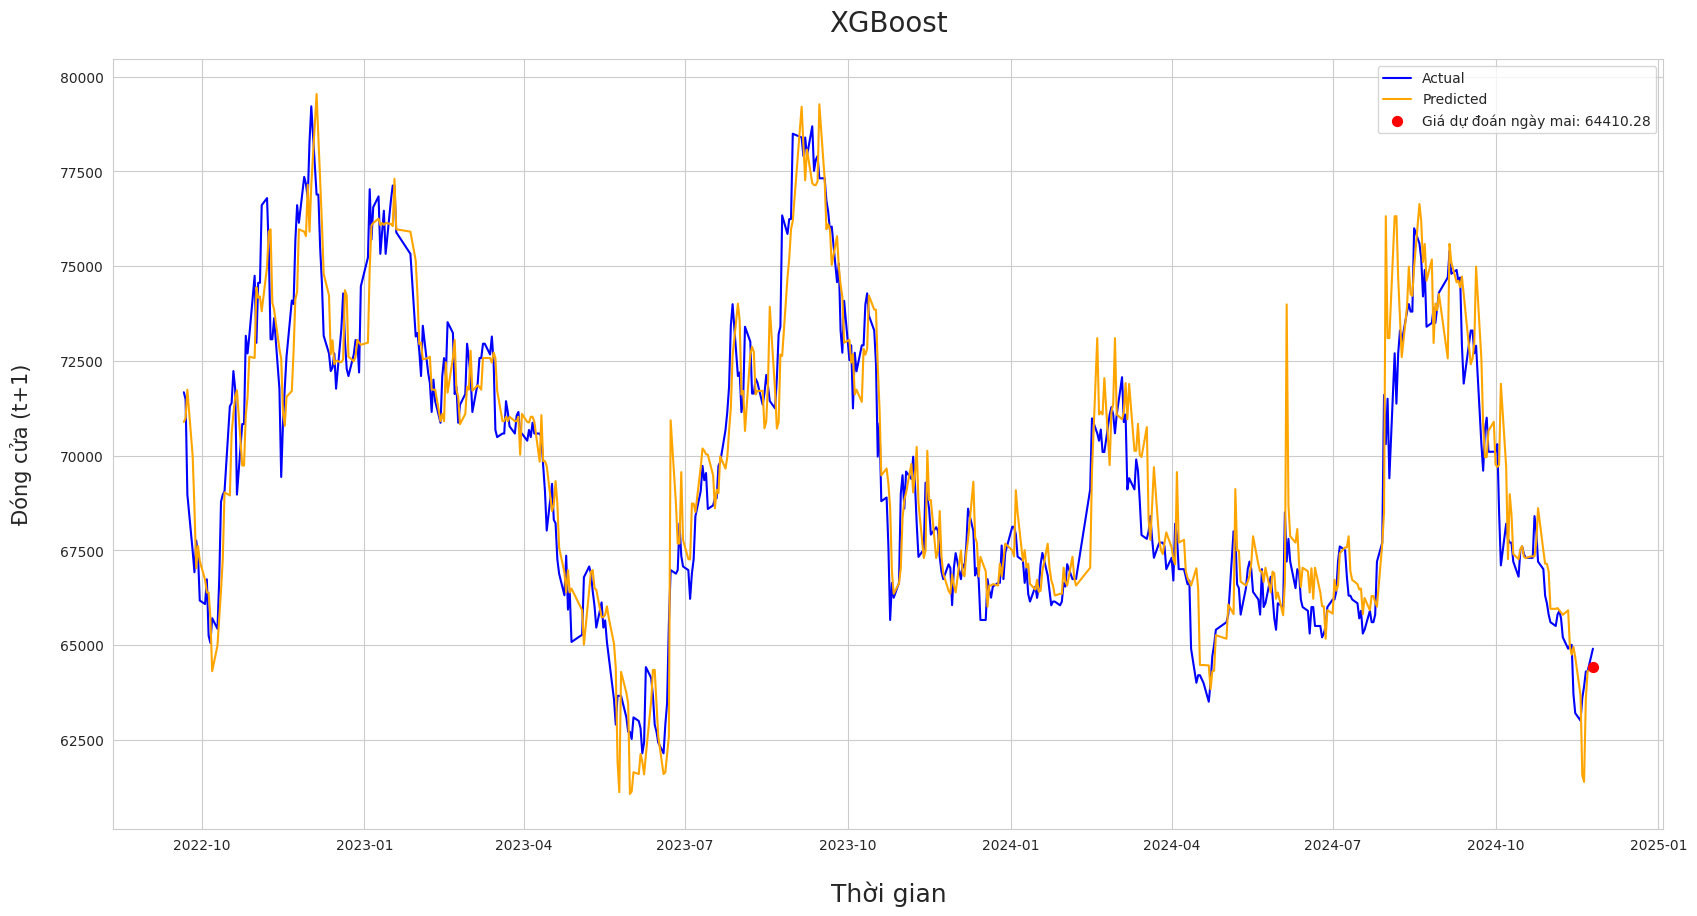

In [ ]:
from xgboost import XGBRegressor

def train_xgboost_model(train, test, input_columns, output_column, date_column):
    train_xgboost = train.copy()
    test_xgboost = test.copy()

    X_train = train_xgboost[input_columns]
    y_train = train_xgboost[output_column]
    X_test = test_xgboost[input_columns]
    y_test = test_xgboost[output_column]

    # Khởi tạo và huấn luyện mô hình
    model = XGBRegressor(n_estimators = 200, learning_rate=0.1, max_depth=3)
    model.fit(X_train, y_train)

    # Dự đoán và đánh giá mô hình
    test_xgboost = test.copy()
    y_pred = model.predict(X_test)
    test_xgboost['Predicted'] = y_pred

    # Hiển thị kết quả
    display(test_xgboost[['Ngày', 'Đóng cửa', output_column, 'Predicted']])

    # Lưu dữ liệu dự đoán của dòng cuối cùng
    last_predicted = test_xgboost.iloc[-1]
    last_predicted_value = last_predicted['Predicted']

    # Tính toán chỉ số đánh giá mô hình
    mae = mean_absolute_error(test_xgboost[output_column], test_xgboost['Predicted'])
    mse = mean_squared_error(test_xgboost[output_column], test_xgboost['Predicted'])
    mape = mean_absolute_percentage_error(test_xgboost[output_column], test_xgboost['Predicted'])
    rmse = np.sqrt(mse)
    r2 = r2_score(test_xgboost[output_column], test_xgboost['Predicted'])

    metrics_df = pd.DataFrame({
        'Metrics': ['R²', 'MAE', 'MSE', 'RMSE', 'MAPE'],
        'Values': [r2, mae, mse, rmse, mape]
    })
    metrics_df['Values'] = metrics_df['Values'].map('{:.4f}'.format)
    display(metrics_df)

    # Lấy ngày tiếp theo mà không có giờ
    next_day = last_predicted['Ngày'].date() + pd.Timedelta(days=1)

    # Lấy giá trị Đóng cửa hiện tại và Predicted cho ngày tiếp theo
    closing_price = last_predicted['Đóng cửa']
    predicted_price = last_predicted['Predicted']

    # So sánh và in ra kết quả
    if predicted_price > closing_price:
        display(f"Giá đóng cửa dự kiến ngày mai {next_day} sẽ cao hơn so với ngày hiện tại.")
    else:
        display(f"Giá đóng cửa dự kiến ngày mai {next_day} sẽ thấp hơn so với ngày hiện tại.")

    # Vẽ đồ thị giá đóng cửa thực tế và dự đoán
    plt.figure(figsize=(20, 10))
    sns.set_style("whitegrid")

    # plt.plot(train[date_column], train[output_column], label='Training', color='green')
    plt.plot(test_xgboost[date_column], test_xgboost[output_column], label='Actual', color='blue')
    plt.plot(test_xgboost[date_column], test_xgboost['Predicted'], label='Predicted', color='orange')
    plt.scatter(last_predicted[date_column], last_predicted_value, color='red', s=50, label=f'Giá dự đoán ngày mai: {last_predicted_value:.2f}', zorder=2)
    plt.title(f"XGBoost", fontsize=20, pad=20)
    plt.xlabel('Thời gian', fontsize=18, labelpad=20)
    plt.ylabel(output_column, fontsize=15, labelpad=20)
    plt.legend()
    plt.show()

    return test_xgboost

# Huấn luyện mô hình
test_xgboost = train_xgboost_model(train, test, input_columns, output_column, date_column)
